<a href="https://colab.research.google.com/github/khaireddine-satouri/plant-dataset/blob/main/Projet_Deep_Learning_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras import regularizers

In [3]:
original_images_train_path = '/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/image'
original_images_test_path = '/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/image'
mask_images_train_path = '/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/label'
mask_images_test_path='/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/label'

In [4]:
import numpy as np
import os
import cv2
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
from skimage import io
import imageio 
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline 

train_image_list=[]
train_mask_list=[]
validation_image_list=[]
validation_mask_list=[]

In [5]:
from natsort import natsorted
sorted_train_images_path=[]
for directory_path in glob(original_images_train_path):
    for img_path in glob(os.path.join(directory_path, "*/*.jpg")):
      sorted_train_images_path.append(img_path)
natsorted(sorted_train_images_path)

['/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/image/Apple_Rust/train_Apple_Rust_3.jpg',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/image/Apple_Rust/train_Apple_Rust_7.jpg',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/image/Apple_Rust/train_Apple_Rust_17.jpg',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/image/Apple_Rust/train_Apple_Rust_34.jpg',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/image/Apple_Rust/train_Apple_Rust_36.jpg',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/image/Apple_Rust/train_Apple_Rust_42.jpg',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/image/Apple_Rust/train_Apple_Rust_45.jpg',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/image/Apple_Rust/train_Apple_Rust_48.jpg',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/image/Apple_Rust/train_Apple_Rust_51.jpg',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/image

In [6]:
for img in natsorted(sorted_train_images_path) :
  train_image_list.append(img)
  #train_labels.append(label)
#Convert list to array for machine learning processing
#train_image_list = np.array(train_image_list,dtype='float16')

In [7]:
from natsort import natsorted
sorted_train_masks_path=[]
for directory_path in glob(mask_images_train_path):
    for img_path in glob(os.path.join(directory_path, "*/*.png")):
      sorted_train_masks_path.append(img_path)
natsorted(sorted_train_masks_path)

['/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/label/Apple_Rust/train_Apple_Rust_3_label.png',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/label/Apple_Rust/train_Apple_Rust_7_label.png',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/label/Apple_Rust/train_Apple_Rust_17_label.png',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/label/Apple_Rust/train_Apple_Rust_34_label.png',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/label/Apple_Rust/train_Apple_Rust_36_label.png',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/label/Apple_Rust/train_Apple_Rust_42_label.png',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/label/Apple_Rust/train_Apple_Rust_45_label.png',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/label/Apple_Rust/train_Apple_Rust_48_label.png',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/label/Apple_Rust/train_Apple_Rust_51_label.png',
 '/content/d

In [8]:
for img in natsorted(sorted_train_masks_path) :
  train_mask_list.append(img)
  #train_labels.append(label)
#Convert list to array for machine learning processing
#train_mask_list = np.array(train_mask_list,dtype='float16')

In [9]:
from natsort import natsorted
sorted_test_images_path=[]
for directory_path in glob(original_images_test_path):
    for img_path in glob(os.path.join(directory_path, "*/*.jpg")):
      sorted_test_images_path.append(img_path)
natsorted(sorted_test_images_path)

['/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/image/Apple_Rust/test_Apple_Rust_1.jpg',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/image/Apple_Rust/test_Apple_Rust_2.jpg',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/image/Apple_Rust/test_Apple_Rust_3.jpg',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/image/Apple_Rust/test_Apple_Rust_6.jpg',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/image/Apple_Rust/test_Apple_Rust_10.jpg',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/image/Apple_Scab/test_Apple_Scab_1.jpg',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/image/Apple_Scab/test_Apple_Scab_3.jpg',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/image/Apple_Scab/test_Apple_Scab_6.jpg',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/image/BellPepper_Spot/test_BellPepper_Spot_1.jpg',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/image/BellPepper_Spo

In [10]:
for img in natsorted(sorted_test_images_path) :
  validation_image_list.append(img)
  #train_labels.append(label)
#Convert list to array for machine learning processing
#validation_image_list = np.array(validation_image_list,dtype='float16')

In [11]:
from natsort import natsorted
sorted_test_masks_path=[]
for directory_path in glob(mask_images_test_path):
    for img_path in glob(os.path.join(directory_path, "*/*.png")):
      sorted_test_masks_path.append(img_path)
natsorted(sorted_test_masks_path)

['/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/label/Apple_Rust/test_Apple_Rust_1_label.png',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/label/Apple_Rust/test_Apple_Rust_2_label.png',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/label/Apple_Rust/test_Apple_Rust_3.png',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/label/Apple_Rust/test_Apple_Rust_6_label.png',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/label/Apple_Rust/test_Apple_Rust_10_label.png',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/label/Apple_Scab/test_Apple_Scab_1_label.png',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/label/Apple_Scab/test_Apple_Scab_3_label.png',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/label/Apple_Scab/test_Apple_Scab_6_label.png',
 '/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/label/BellPepper_Spot/test_BellPepper_Spot_1_label.png',
 '/content/drive/MyDrive/Projet_

In [12]:
validation_mask_list=[]
for img in natsorted(sorted_test_masks_path) :
  validation_mask_list.append(img)
  #train_labels.append(label)
#Convert list to array for machine learning processing
#validation_mask_list = np.array(validation_mask_list,dtype='float16')

(270, 270, 3)
(270, 270, 4)


Text(0.5, 1.0, 'Mask')

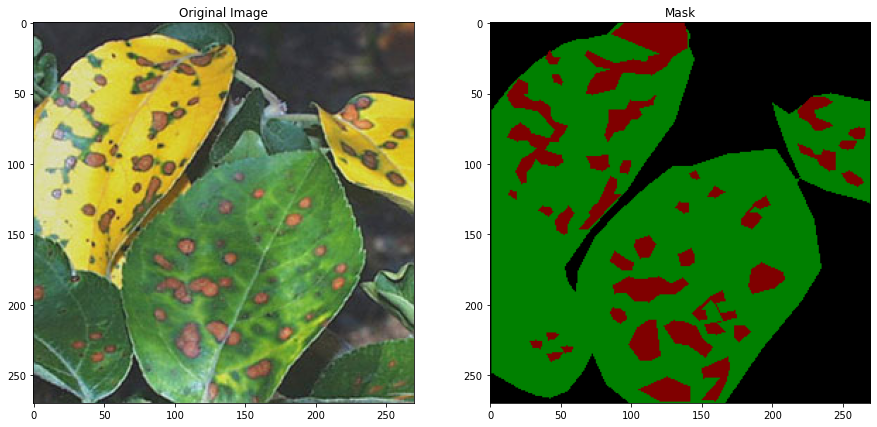

In [13]:
n = 10 # you can chose any index 
img  = imageio.imread(train_image_list[n])
print(img.shape)
mask = imageio.imread(train_mask_list[n])
print(mask.shape)

# now let's plot 
fig ,arr  = plt.subplots(1,2,figsize=(15,10))
arr[0].imshow(img)
arr[0].set_title('Original Image')
arr[1].imshow(mask)
arr[1].set_title('Mask')

In [14]:
train_images = tf.constant(train_image_list)
train_masks = tf.constant(train_mask_list)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_masks))
for image,mask in train_dataset.take(1) : 
    print(image)
    print(mask)
    
validation_images = tf.constant(validation_image_list)
validation_masks = tf.constant(validation_mask_list)

validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images,validation_masks))
for image,mask in validation_dataset.take(1) : 
    print(image)
    print(mask)

tf.Tensor(b'/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/image/Apple_Rust/train_Apple_Rust_3.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/label/Apple_Rust/train_Apple_Rust_3_label.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/image/Apple_Rust/test_Apple_Rust_1.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/label/Apple_Rust/test_Apple_Rust_1_label.png', shape=(), dtype=string)


In [15]:
def process_path(image_path,mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img,channels=3)
    img = tf.image.convert_image_dtype(img,tf.float32) #this do the same as dividing by 255 to set the values between 0 and 1 (normalization)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask,channels=1)
    mask = tf.math.reduce_max(mask,axis=-1,keepdims=True)
    return img , mask

def preprocess(image,mask) : 
    input_image = tf.image.resize(image,(96,128),method='nearest')
    input_mask = tf.image.resize(mask,(96,128),method='nearest')
    
    return input_image , input_mask

train_image_ds = train_dataset.map(process_path) # apply the preprocces_path function to our train_dataset
print(train_image_ds)
train_processed_image_ds = train_image_ds.map(preprocess) # apply the preprocess function to our train_dataset

validation_image_ds = validation_dataset.map(process_path) # apply the preprocces_path function to our validation_dataset
print(train_image_ds)
validation_processed_image_ds = validation_image_ds.map(preprocess) 

<MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None))>


In [16]:
def EncoderMiniBlock(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)
   
    

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [17]:
def DecoderMiniBlock(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    
    return conv

In [18]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=129):
    
    inputs = Input(input_size)
    
    # contracting path
    cblock1 = EncoderMiniBlock(inputs, n_filters, dropout_prob=0.4)
    cblock2 = EncoderMiniBlock(cblock1[0], 2*n_filters, dropout_prob=0.4)
    cblock3 = EncoderMiniBlock(cblock2[0], 4*n_filters, dropout_prob=0.4)
    cblock4 = EncoderMiniBlock(cblock3[0], 8*n_filters, dropout_prob=0.45) 
    cblock5 = EncoderMiniBlock(cblock4[0],16*n_filters, dropout_prob=0.4, max_pooling=None)     
    
    # expanding path
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters*4)
    ublock8 = DecoderMiniBlock(ublock7,cblock2[1] , n_filters*2)
    ublock9 = DecoderMiniBlock(ublock8,cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)  
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model



In [19]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

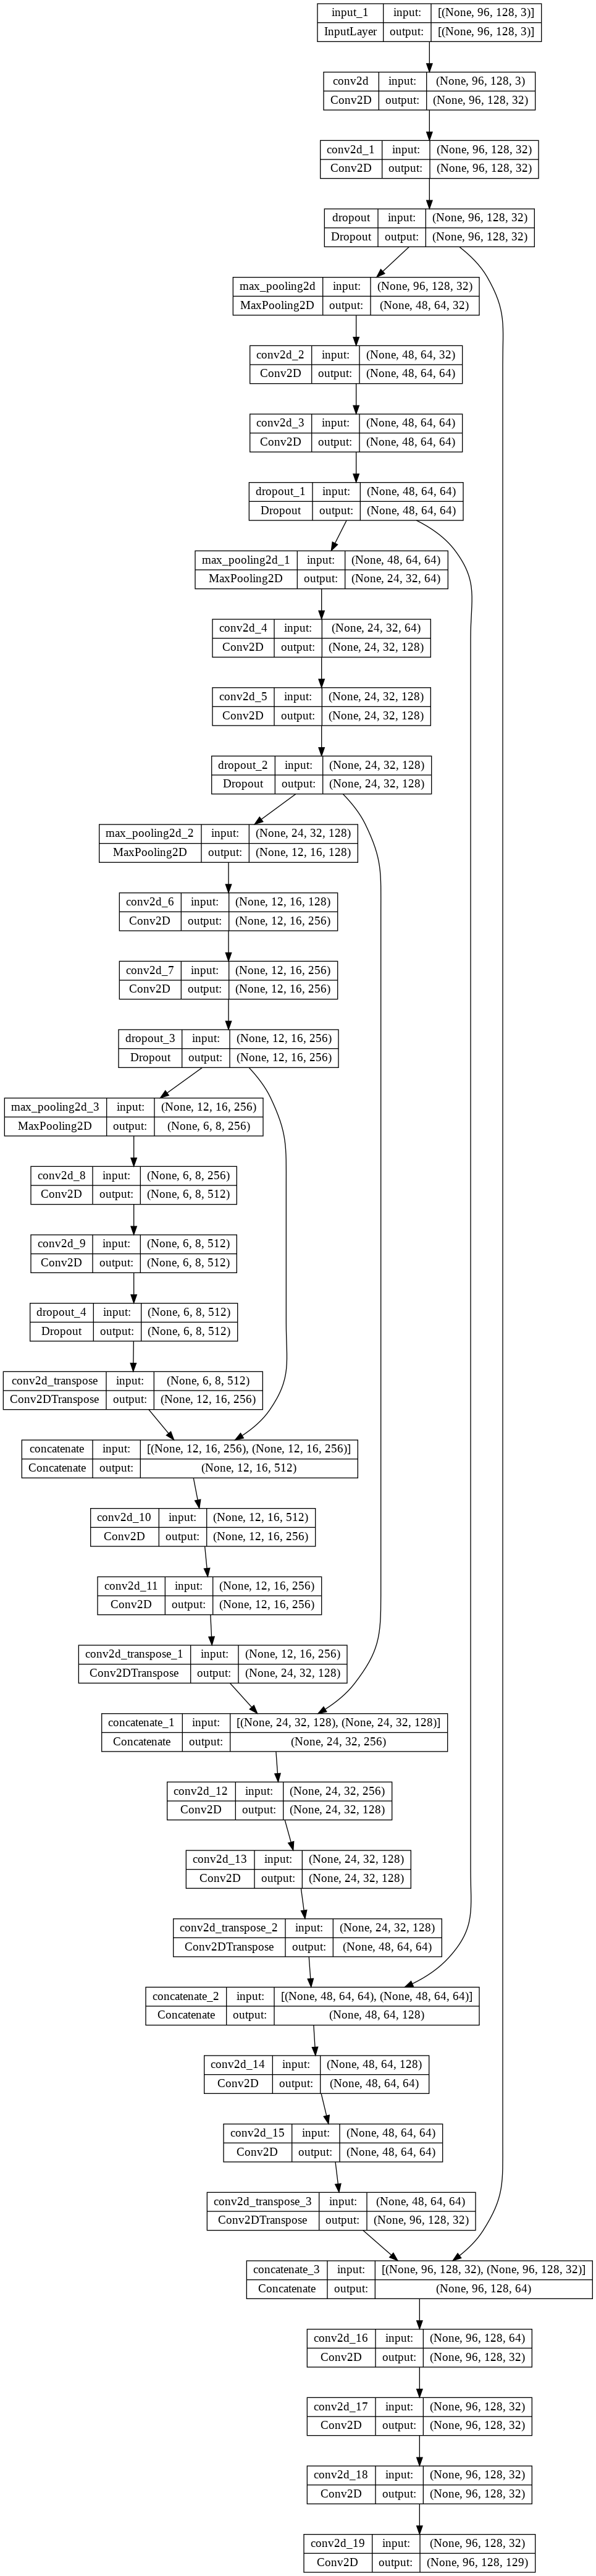

In [20]:
import tensorflow as tf
tf.keras.utils.plot_model(unet, show_shapes=True)

In [21]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
EPOCHS = 100
VAL_SUBSPLITS = 5
BUFFER_SIZE = 390
BATCH_SIZE = 16

# train
train_processed_image_ds.batch(BATCH_SIZE)
train_dataset = train_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_processed_image_ds.element_spec)

# validation
validation_processed_image_ds.batch(BATCH_SIZE)
validation_dataset = validation_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(validation_processed_image_ds.element_spec)
 

model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/100
29/29 [==============================] - 26s 159ms/step - loss: 2.8767 - accuracy: 0.4325
Epoch 2/100
29/29 [==============================] - 3s 93ms/step - loss: 1.1615 - accuracy: 0.4860
Epoch 3/100
29/29 [==============================] - 3s 93ms/step - loss: 0.9677 - accuracy: 0.5319
Epoch 4/100
29/29 [==============================] - 3s 94ms/step - loss: 0.8649 - accuracy: 0.6157
Epoch 5/100
29/29 [==============================] - 3s 94ms/step - loss: 0.8886 - accuracy: 0.6002
Epoch 6/100
29/29 [==============================] - 3s 95ms/step - loss: 0.7760 - accuracy: 0.6691
Epoch 7/100
29/29 [==============================] - 3s 95ms/step - loss: 0.7852 - accuracy: 0.6569
Epoch 8/100
29/29 [==============================] - 3s 

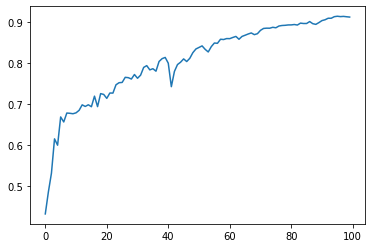

In [23]:
plt.plot(model_history.history["accuracy"])

In [24]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [25]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [26]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

----- training_dataset results---------
1/1 [==============================] - 0s 247ms/step


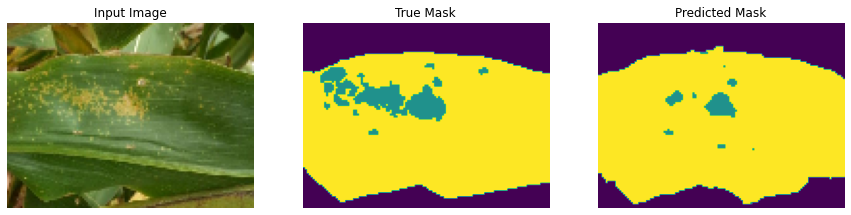

1/1 [==============================] - 0s 19ms/step


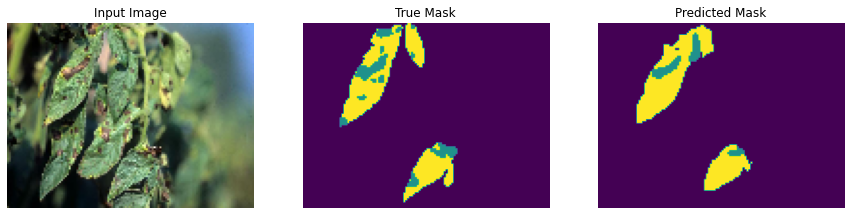

1/1 [==============================] - 0s 25ms/step


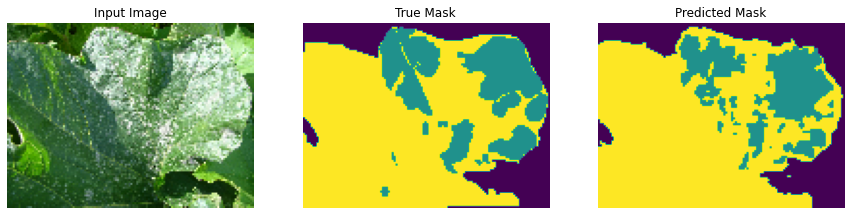

1/1 [==============================] - 0s 26ms/step


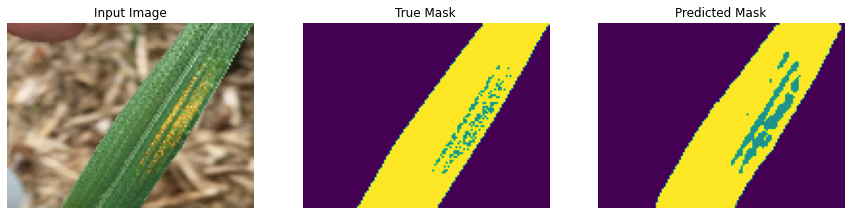

1/1 [==============================] - 0s 18ms/step


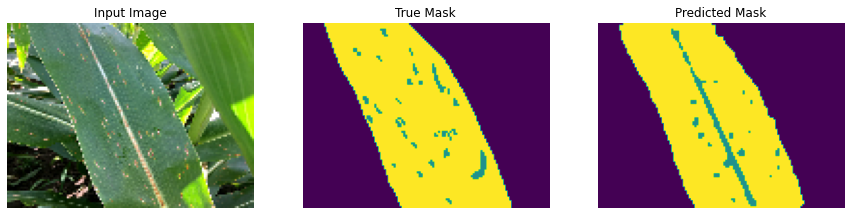

1/1 [==============================] - 0s 27ms/step


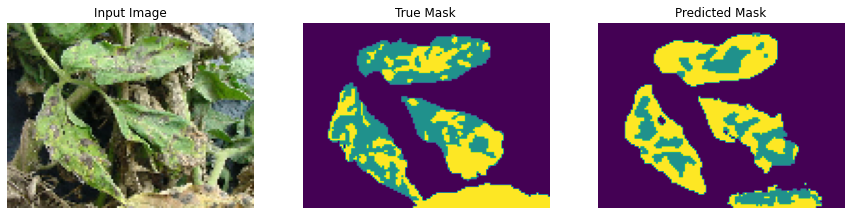

----- validation_dataset results---------
1/1 [==============================] - 0s 18ms/step


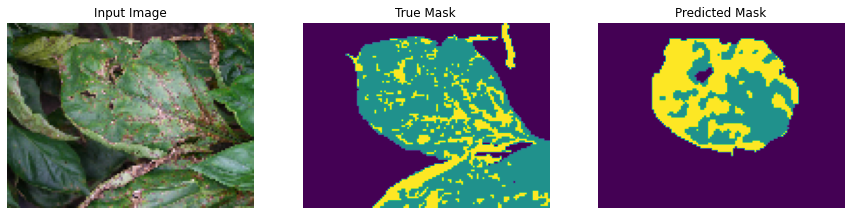

1/1 [==============================] - 0s 25ms/step


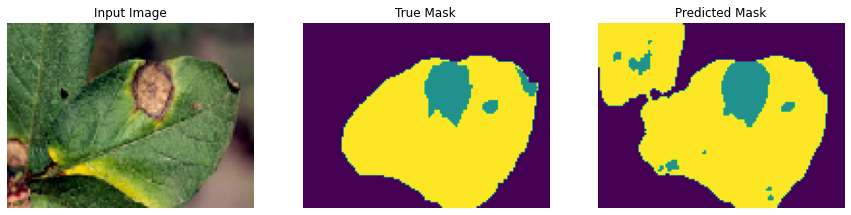

1/1 [==============================] - 0s 21ms/step


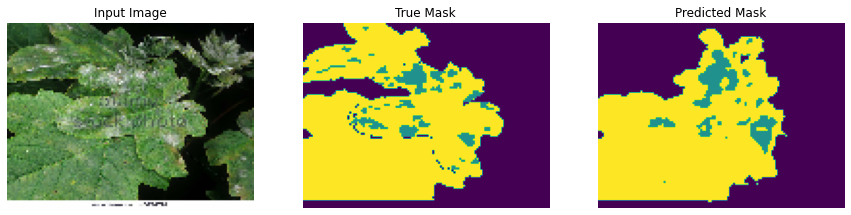

1/1 [==============================] - 1s 767ms/step


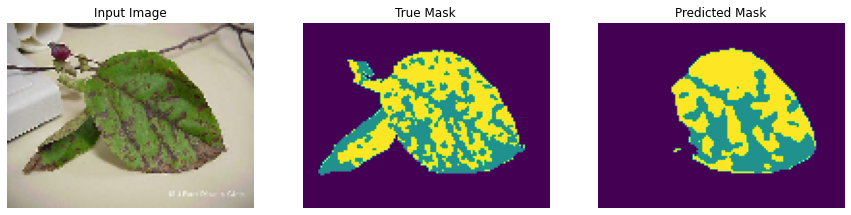

In [27]:
print("----- training_dataset results---------")
show_predictions(train_dataset, 6)
print("----- validation_dataset results---------")
show_predictions(validation_dataset, 6)

In [28]:
# model evaluation
print("Unet Model Evaluation: ")
unet.evaluate(validation_dataset)

Unet Model Evaluation: 
4/4 [==============================] - 0s 32ms/step - loss: 0.5569 - accuracy: 0.8392


[0.556915283203125, 0.8391613960266113]